In [1]:
# !pip install jsonpickle
# !pip install py-ecg-detectors

In [2]:
import os
import pandas as pd
import hashlib
import jsonpickle
import pathlib
import warnings
import matplotlib.pyplot as plt

In [3]:
DATA_PATHS = ["../Data/2/", "../Data/3/", "../Data/6/", "../Data/4/", "../Data/5/", "../ECG_random_samples/"]
SAMPLING_RATE = 256

In [4]:
import jsonpickle

USER_DATA_PATH = "../labelled/"


class FileHolder(object):
    prev_x = 0
    prev_y = 1500

    def __init__(self):
        self.channel_holders = {}
        self.md5 = ""
        self.current_channel = ""
        self.prev_x = 0
        self.prev_y = 1500

    @staticmethod
    def get_file_path(md5):
        gt_file_name = "{}.json".format(md5)
        gt_file_path = USER_DATA_PATH + gt_file_name
        return gt_file_path

    def write_to_file(self, username):
        frozen = jsonpickle.encode(self)
        # print(frozen)
        gt_file_path = self.get_file_path(self.md5, username)
        ground_truth_txt = open(gt_file_path, "w")  # write mode
        ground_truth_txt.write("{}\n".format(frozen))
        ground_truth_txt.close()


    def load_file_holder(username, md5):
        file_path = FileHolder.get_file_path(md5, username)
        file_storage = jsonpickle.decode(open(file_path, "r").read())
        return file_storage

In [5]:
def myfunc(n):
    return n['py/tuple']


def map_value_to_index(n):
    # return [n, df.iloc[n]['# ECG Channel 1']]
    return [n, df.iloc[n][:, 0]]

In [6]:
from ecgdetectors import Detectors
detectors = Detectors(SAMPLING_RATE)

In [9]:
import numpy as np
def calibrate_algo(detector_func):
    header = "{:<35} {:<5} {:<5} {:<5} {:<6} {:<6} {:<10} {:<10}"\
                .format("Filename", "TP", "FP", "FN", "SE", "PR", "DET_COUNT","REF_COUNT")
    separator = "-" * len(header)
    file_not_found = []
    sen_sum = 0
    pre_sum = 0
    f_count = 0
    print(header)
    print(separator)
    tols = []
    sens = []
    precs = []
    for tol in range(50, -1, -1):
        tols.append(tol)
        for DATA_PATH in DATA_PATHS:
            for r, d, f in os.walk(DATA_PATH):
                    for file in f:
                        if file.endswith(".csv"):
                            md5_hash = hashlib.md5()
                            file_path = DATA_PATH + file
                            a_file = open(file_path, "rb")
                            content = a_file.read()
                            md5_hash.update(content)
                            digest = md5_hash.hexdigest()

                            df = pd.read_csv(file_path)
        #                     print(file_path)
                            r_peaks = detector_func(df.iloc[:, 0])
        #                     r_peaks = detectors.pan_tompkins_detector(df['# ECG Channel 1'])
                            #r_peaks = detectors.hamilton_detector(df['# ECG Channel 1'])

                            file_path = FileHolder.get_file_path(digest)
                            json_file_path = pathlib.Path(file_path)
                            #print(digest)

                            if json_file_path.exists():
                                with open(json_file_path, "r") as json_file:
                                    file_storage = jsonpickle.decode(json_file.read())
                                    labelled_peak_set = file_storage['channel_holders']['# ECG Channel 1']['py/set']

                                    labelled_peak_set = sorted(list(map(myfunc, labelled_peak_set)), key=lambda item: item[0])
                                    reference = list(map(lambda x: x[0], labelled_peak_set))
                                    max_peak_len = max(len(labelled_peak_set), len(r_peaks))

                                    TP = 0
                                    delay = 0

                                    for anno_value in r_peaks:
                                        test_range = np.arange(anno_value-tol-delay, anno_value+1+tol-delay)
                                        in1d = np.in1d(test_range, reference)
                                        if np.any(in1d):
                                            TP = TP + 1

                                    FP = len(r_peaks) - TP
                                    FN = len(reference) - TP
                                    if (TP + FN == 0):
                                        continue
                                    sensitivity = TP / (TP + FN)
                                    precision = TP / (TP + FP)
                                    sen_sum += sensitivity
                                    pre_sum += precision
                                    f_count += 1
                                    a_row = "{:<35} {:<5} {:<5} {:<5} {:<6.2f} {:<6.2f} {:<10} {:<10}"\
                                        .format(digest, TP, FP, FN, sensitivity, precision, len(r_peaks), len(reference))
                                    print(a_row)
                            else:
                                file_not_found.append((file, digest))
        print(separator)
        print(f"Avearage Sensitivity: {sen_sum/f_count}")
        print(f"Precision: {pre_sum/f_count}")
        sens.append(sen_sum/f_count)
        precs.append(pre_sum/f_count)

        for fnf in file_not_found:
            warnings.warn(f"File not exist {fnf[0]} {fnf[1]}")
        print(f"Total File Missing: {len(file_not_found)}")
        
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Horizontally stacked subplots')
    ax1.plot(tols, sens)
    ax2.plot(tols, precs)

In [21]:
def plot_algo_result(detector_func):
    
    file_not_found = []
    sen_sum = 0
    pre_sum = 0
    f_count = 0
    tols = []
    sens = []
    precs = []
    for tol in range(50, -1, -1):
        tols.append(tol)
        for DATA_PATH in DATA_PATHS:
            for r, d, f in os.walk(DATA_PATH):
                    for file in f:
                        if file.endswith(".csv"):
                            md5_hash = hashlib.md5()
                            file_path = DATA_PATH + file
                            a_file = open(file_path, "rb")
                            content = a_file.read()
                            md5_hash.update(content)
                            digest = md5_hash.hexdigest()

                            df = pd.read_csv(file_path)
        #                     print(file_path)
                            r_peaks = detector_func(df.iloc[:, 0])
        #                     r_peaks = detectors.pan_tompkins_detector(df['# ECG Channel 1'])
                            #r_peaks = detectors.hamilton_detector(df['# ECG Channel 1'])

                            file_path = FileHolder.get_file_path(digest)
                            json_file_path = pathlib.Path(file_path)
                            #print(digest)

                            if json_file_path.exists():
                                with open(json_file_path, "r") as json_file:
                                    file_storage = jsonpickle.decode(json_file.read())
                                    labelled_peak_set = file_storage['channel_holders']['# ECG Channel 1']['py/set']

                                    labelled_peak_set = sorted(list(map(myfunc, labelled_peak_set)), key=lambda item: item[0])
                                    reference = list(map(lambda x: x[0], labelled_peak_set))
                                    max_peak_len = max(len(labelled_peak_set), len(r_peaks))

                                    TP = 0
                                    delay = 0

                                    for anno_value in r_peaks:
                                        test_range = np.arange(anno_value-tol-delay, anno_value+1+tol-delay)
                                        in1d = np.in1d(test_range, reference)
                                        if np.any(in1d):
                                            TP = TP + 1

                                    FP = len(r_peaks) - TP
                                    FN = len(reference) - TP
                                    if (TP + FN == 0):
                                        continue
                                    sensitivity = TP / (TP + FN)
                                    precision = TP / (TP + FP)
                                    sen_sum += sensitivity
                                    pre_sum += precision
                                    f_count += 1
                            else:
                                file_not_found.append((file, digest))
        sens.append(sen_sum/f_count)
        precs.append(pre_sum/f_count)

#     for fnf in file_not_found:
#         warnings.warn(f"File not exist {fnf[0]} {fnf[1]}")
#     print(f"Total File Missing: {len(file_not_found)}")
    tols = list(map(lambda x: x / 256, tols))
        
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.tight_layout()
    ax1.plot(tols, sens)
    ax2.plot(tols, precs)
    ax1.set_title('Sensitivity over time tolerance')
    ax2.set_title('Precision over time tolerance')
    ax1.set(xlabel='Time (second)', ylabel='Sensitivity')
    ax2.set(xlabel='Time (second)', ylabel='Precision')

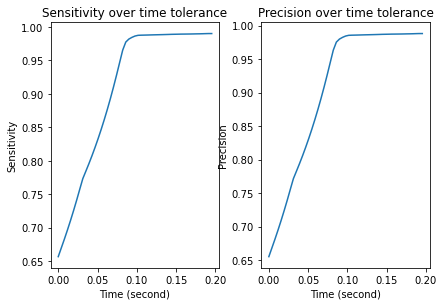

In [22]:
plot_algo_result(detectors.pan_tompkins_detector)

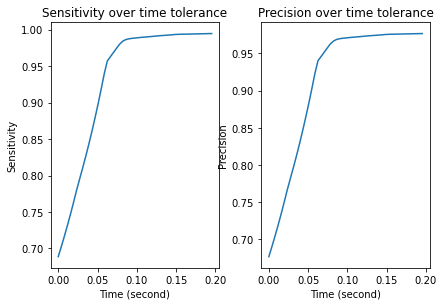

In [23]:
plot_algo_result(detectors.hamilton_detector)

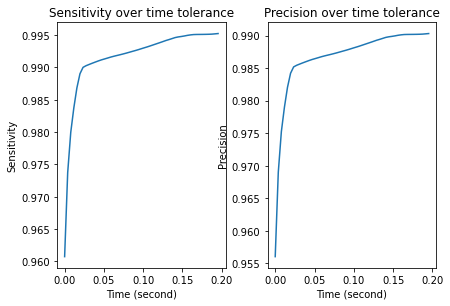

In [24]:
plot_algo_result(detectors.christov_detector)

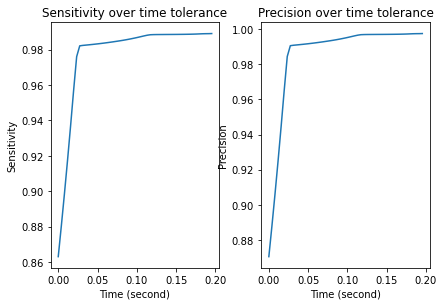

In [25]:
plot_algo_result(detectors.swt_detector)

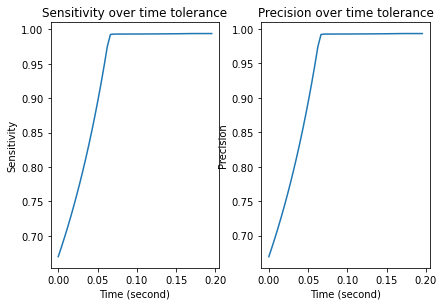

In [26]:
plot_algo_result(detectors.two_average_detector)